# DiagrammeR Viz in Jupyter Python notebook


In [2]:
import rpy2

# Enables R line magic (%R) and cell magic (%%R)
%load_ext rpy2.ipython 

# # r enables calls to r objects and 
# # pandas2ri allows conversion both ways
# from rpy2.robjects import r, pandas2ri    

# Ignore rpy2 RRuntimeWarning complaining
# about packages, they work fine!
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Enables rendering a string of HTML code 
# as an image
from IPython.display import display, HTML

The code cell below shows an example of DiagrammeR. It's mostly gleaned from the source below the image with a few added aesthetic changes. 


To get the code below to work correctly and print inline instead of to a new window on Mac OSX, you will likely need to do the following first:

In a terminal "brew install v8@3.15"

In R "install.packages("v8");install.packages("DiagrammeR");install.packages("DiagrammeRsvg")

In [3]:
%%R

library(DiagrammeR)
library(DiagrammeRsvg) # provides export_svg command

plot.script <- paste("digraph 'ER-D' {",
                         "graph [layout = neato]",
                         "node [",
                             "style = filled,",
                             "penwidth = 3",
                         "]",
                         "node [",
                             "color = royalblue,",
                             "fillcolor = cornflowerblue,",
                             "shape = egg,",
                             "width = 01.00",
                         "]",
                         "aisles",
                         "departments",
                         "orders",
                         "products",
                         "order_products__",
                         "node [",
                             "color = forestgreen,",
                             "fillcolor = darkseagreen,",
                             "shape = box,",
                             "width = 0.40,",
                             "height = 0.30,",
                             "fontsize = 9",
                         "]",
                         "edge [",
                             "color = grey,",
                             "arrowhead = none",
                         "]",
                         "aisles -> {",
                             "aisle_id",
                             "aisle",
                         "}",
                         "departments -> {",
                             "department_id",
                             "department",
                         "}",       
                         "orders -> {",
                             "order_id",
                             "user_id",
                             "eval_set",
                             "order_number",
                             "order_dow",
                             "order_hour_of_day",
                             "days_since_prior_order",
                         "}",
                         "products -> {",
                             "product_id",
                             "product_name",
                             "aisle_id",
                             "department_id",
                         "}",
                         "order_products__ -> {",
                             "order_id",
                             "product_id",
                             "add_to_cart_order",
                             "reordered",
                         "}",
                     "}", sep=" ")
svg <- export_svg(grViz(plot.script))

In [4]:
display(HTML(rpy2.robjects.r.svg[0]))

I really like this DiagrammeR package. Using the settings above it reminds me of the sklearn cheat sheet.

[Source](https://www.kaggle.com/kenny21143/entity-relationship-diagram "https://www.kaggle.com/kenny21143/entity-relationship-diagram")
[(made with DiagrammeR)](http://rich-iannone.github.io/DiagrammeR/ "http://rich-iannone.github.io/DiagrammeR/")

# R vs Python for reading data and importing data into the other language

Everyone still using pandas.read_csv() needs to read this. A much faster option is fread() from the R package data.table. On my late 2012 MBPr, using fread() instead of read_csv() makes a ~0.5GB data read take a few seconds instead of a few minutes. The reason behind this is that pandas.read_csv() is python based while fread() is C based.

Further, reading into R and importing into python is much faster than the reverse process. When you read into python using pandas.read_csv() and then import into R using pandas2ri.py2ri(), you have made two complete copies of the data in memory. When you read into R using "data <- fread()" and then import into python using "py_var = pandas2ri.ri2py(r.data)" something different happens. A vector pointer is created instead of making a complete copy of the data. The creation of the vector pointer is almost instantaneous, while a complete copy of the data is unbearably slow for anything larger than ~0.5GB.


Like the reading of the data, the importing from one to the other takes a long time from Python to R and seconds from R to python.

If you prefer using Python, consider using R as a speed loader for your data.


In [5]:
%%R

library(data.table) # for fread()
library(dplyr) # data table manipulation (joins, group_by, etc)

orders <- fread('/Users/andrew/Desktop/data/orders.csv')
products <- fread('/Users/andrew/Desktop/data/products.csv')
aisles <- fread('/Users/andrew/Desktop/data/aisles.csv')
departments <- fread('/Users/andrew/Desktop/data/departments.csv')
order_products <- fread(paste('/Users/andrew/Desktop/data/',
                               'order_products__train.csv', sep=""))


# Combine aisle and deparment data with product data
tmp <- products %>% 
    group_by(department_id, aisle_id) %>% 
    summarise(n_items=n()) %>% 
    left_join(departments,by="department_id") %>% 
    left_join(aisles,by="aisle_id")

# Combine with order_products__(train) to find total items sold in 
# each aisle as n_orders
goods<-order_products %>% 
  group_by(product_id) %>% 
  summarize(count=n()) %>% 
  left_join(products,by="product_id") %>% 
  ungroup() %>% 
  group_by(department_id,aisle_id) %>% 
  summarize(n_orders = sum(count)) %>% 
  left_join(tmp, by = c("department_id", "aisle_id")) %>% 
  mutate(onesize = 1)


Now let's check out the header on the data frame we just made.

In [6]:
# 
%R goods %>% head(1)

,department_id,aisle_id,n_orders,n_items,department,aisle,onesize
1,1,34,3341,229,frozen,frozen meat seafood,1.0


Here you can see how to print just the columns you are interested in viewing.

Notice how the %R call prints the data.table object from R into a pandas data-frame output.

In [7]:
# select n_orders and aisles column from goods in R
%R goods_tmp <- goods[ ,c(6,3)] 
%R goods_tmp %>% head(5) 

,aisle,n_orders
1,frozen meat seafood,3341
2,ice cream ice,22676
3,frozen meals,18221
4,frozen vegan vegetarian,4727
5,frozen breakfast,9729


# Wordcloud Viz in Python

The python version of wordcloud is superior to the R version because you can use images as a mask and you can use the colors in the image as the color scheme!

Dependencies:

In a terminal run "conda install -c conda-forge wordcloud=1.2.1; conda install pillow"

[Source](https://amueller.github.io/word_cloud/auto_examples/colored.html "https://amueller.github.io/word_cloud/auto_examples/colored.html")

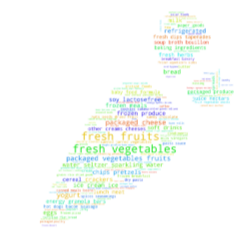

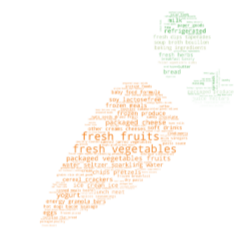

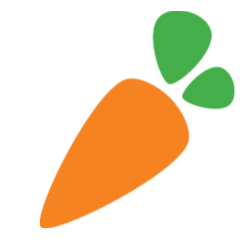

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

path = '/Users/andrew/Desktop/data/'
im_path = path + 'instacart_color.png'
im_out_path = 'instacart_wc.png'

# select n_orders and aisles column from goods in R
%R goods_tmp <- goods[ ,c(6,3)] 

# make goods_tmp into pandas data frame in Python
goods = rpy2.robjects.pandas2ri.ri2py(rpy2.robjects.r.goods_tmp) 

# convert data-frame to list of lists for consumption
#  by wordcloud.generate_from_frequencies(frequencies=d)
d = goods.values.tolist()

# set stop words
stopwords = set(STOPWORDS)
stopwords.add("said")

# read the mask image
instacart_image = np.array(Image.open(im_path))

# create coloring from image
image_colors = ImageColorGenerator(instacart_image)

# create wordcloud object
wc = WordCloud(background_color="white", max_words=134, 
               mask=instacart_image, stopwords=stopwords)

# get word counts directly from list of lists
wc.generate_from_frequencies(frequencies=d)



# plot figure
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

# plot figure
plt.figure()
plt.imshow(wc.recolor(color_func=image_colors), 
           interpolation="bilinear")
plt.axis("off")

# store to file
wc.to_file(im_out_path)

# plot figure
plt.figure()
plt.imshow(instacart_image, cmap=plt.cm.gray, 
           interpolation='bilinear')
plt.axis("off")

# show plot
plt.show()